In [1]:
import pandas as pd
import numpy as np
import os
import igraph as ig
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

# 设置工作路径
work_dir = '../2/ml-25m/'
os.chdir(work_dir)

In [2]:
# 读取数据
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')
genome_scores = pd.read_csv('genome-scores.csv')
genome_tags = pd.read_csv('genome-tags.csv')

# 筛选出评分大于2的记录
ratings = ratings[ratings['rating'] > 2]

# 筛选出评分次数大于50次的用户
user_counts = ratings['userId'].value_counts()
active_users = user_counts[user_counts > 50].index
ratings_active = ratings[ratings['userId'].isin(active_users)]

# 数据采样：随机抽取0.1%的数据
ratings_sample = ratings_active.sample(frac=0.001, random_state=42)

# 打印数据概览
print(ratings_sample.head(5))
print(movies.head(5))
print(genome_scores.head(5))
print(genome_tags.head(5))

          userId  movieId  rating   timestamp
24661196  160256    46862     2.5  1508319721
10313888   66909     1342     3.5  1398447060
17235830  111669      457     5.0  1545947128
15104641   97897     1566     5.0   961095820
8698809    56673     2692     4.0  1036969613
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   movieId  tagId  relevance
0        1      1    0.02875
1        1      2    0.02375
2        1      3    0.06250
3        1   

In [3]:
# 计算用户画像
user_profiles = {}

def calculate_user_profiles(ratings_sample, genome_scores):
    # 构建电影特征矩阵
    movie_features = genome_scores.pivot(index='movieId', columns='tagId', values='relevance').fillna(0)

    # 初始化用户画像字典
    for user_id, group in ratings_sample.groupby('userId'):
        user_profile = np.zeros(movie_features.shape[1])
        total_rating = 0
        for _, row in group.iterrows():
            movie_id = row['movieId']
            rating = row['rating']
            if movie_id in movie_features.index:
                movie_feature = movie_features.loc[movie_id].values
                user_profile += rating * movie_feature
                total_rating += rating
        if total_rating > 0:
            user_profiles[user_id] = user_profile / total_rating
        else:
            user_profiles[user_id] = user_profile

    return user_profiles

user_profiles = calculate_user_profiles(ratings_sample, genome_scores)

# 将用户画像转换为DataFrame并保存
user_profiles_df = pd.DataFrame.from_dict(user_profiles, orient='index')
user_profiles_df.reset_index(inplace=True)
user_profiles_df.columns = ['userId'] + [f'feature_{i}' for i in range(1, user_profiles_df.shape[1])]
user_profiles_df.to_csv('user_profiles.csv', index=False)

print("User profiles have been calculated and saved.")

User profiles have been calculated and saved.


In [4]:
# 构建用户偏好图数据框
user_preferences = []

# 为每个用户创建一个评分字典
user_ratings = ratings_sample.groupby('userId')['movieId'].apply(set).to_dict()

# 获取所有用户ID
users = list(user_ratings.keys())
num_users = len(users)

# 使用tqdm显示进度条
for i in tqdm(range(num_users), desc="Calculating common ratings"):
    for j in range(i + 1, num_users):
        user1 = users[i]
        user2 = users[j]
        common_movies = user_ratings[user1].intersection(user_ratings[user2])
        if len(common_movies) >= 2:  # 共同评分至少2部电影
            user_preferences.append([user1, user2, len(common_movies)])

# 构建用户偏好图数据框
user_preferences_df = pd.DataFrame(user_preferences, columns=['from', 'to', 'weight'])

# 保存用户偏好图数据框
user_preferences_df.to_csv('graph_representation.csv', index=False)

print("User preference graph has been saved.")

Calculating common ratings: 100%|██████████| 15910/15910 [00:20<00:00, 786.31it/s] 

User preference graph has been saved.


In [5]:
user_preferences_df

,from,to,weight
0,12950,94498,2
1,18765,150706,2
2,74234,81403,2
3,81017,158728,2
4,124059,147614,2


In [6]:
# # 读取用户画像
# user_profiles_df = pd.read_csv('user_profiles.csv')

# # 读取用户偏好图
# user_preferences_df = pd.read_csv('graph_representation.csv')

In [12]:
import igraph as ig
from scipy.sparse import csr_matrix, diags
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 读取用户画像
user_profiles_df = pd.read_csv('user_profiles.csv')

# 读取用户偏好图
user_preferences_df = pd.read_csv('graph_representation.csv')

# 构建图对象并设置顶点属性
user_ids = user_profiles_df['userId'].tolist()
user_id_to_index = {user_id: index for index, user_id in enumerate(user_ids)}
edges = [(user_id_to_index[row['from']], user_id_to_index[row['to']]) for _, row in user_preferences_df.iterrows()]
weights = user_preferences_df['weight'].tolist()

# 确保每个用户 ID 都作为顶点添加到图中
graph = ig.Graph()
graph.add_vertices(len(user_ids))
graph.vs['name'] = user_ids
graph.add_edges(edges)
graph.es['weight'] = weights

# 获取边的权重及对应的节点对
edges = graph.get_edgelist()
weights = graph.es['weight']

# 构建稀疏邻接矩阵
num_nodes = graph.vcount()
row_ind = [edge[0] for edge in edges]
col_ind = [edge[1] for edge in edges]
adjacency_matrix_sparse = csr_matrix((weights, (row_ind, col_ind)), shape=(num_nodes, num_nodes))

# 转换为密集矩阵以便打印（仅用于检查）
adjacency_matrix = adjacency_matrix_sparse.toarray()
print(f"adjacency_matrix: {adjacency_matrix}")

# 计算度矩阵
degree_matrix = diags(adjacency_matrix_sparse.sum(axis=1).A.flatten(), offsets=0)

# 计算拉普拉斯矩阵
laplacian_matrix = degree_matrix - adjacency_matrix_sparse

print("Adjacency, Degree, and Laplacian matrices have been calculated.")

# 检查用户画像中的用户与图中的节点是否一致
graph_user_ids = set(graph.vs['name'])
profile_user_ids = set(user_profiles_df['userId'])
missing_in_profiles = graph_user_ids - profile_user_ids
missing_in_graph = profile_user_ids - graph_user_ids

if missing_in_profiles:
    print(f"Warning: Users in graph but not in profiles: {missing_in_profiles}")
if missing_in_graph:
    print(f"Warning: Users in profiles but not in graph: {missing_in_graph}")

# 确保用户画像矩阵的行数与拉普拉斯矩阵的维度一致
user_profiles_df = user_profiles_df[user_profiles_df['userId'].isin(graph_user_ids)]
user_profiles_matrix = user_profiles_df.drop('userId', axis=1).values

# 检查维度匹配
assert laplacian_matrix.shape[0] == user_profiles_matrix.shape[0], "Dimension mismatch between Laplacian matrix and user profile matrix."

# 计算M矩阵
M = laplacian_matrix.dot(user_profiles_matrix)

adjacency_matrix: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Adjacency, Degree, and Laplacian matrices have been calculated.


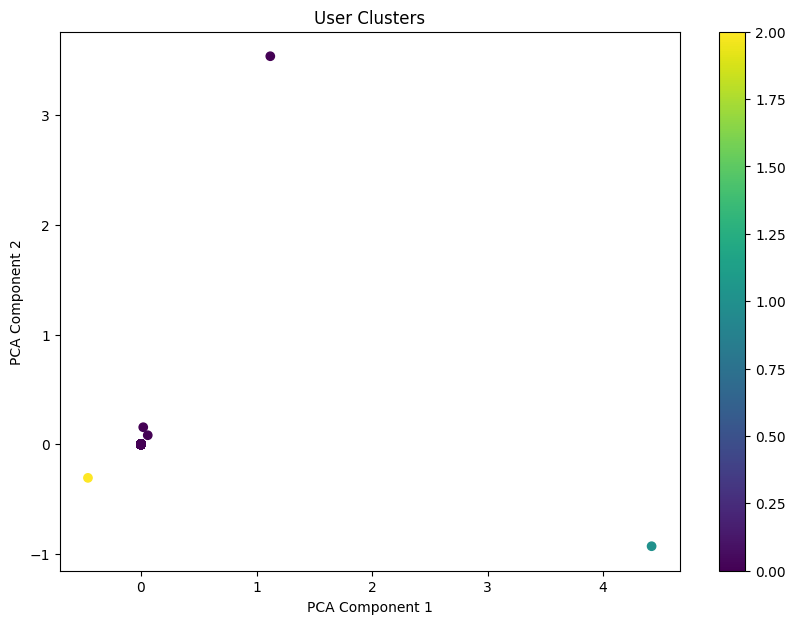

PCA and K-means clustering have been performed.


In [14]:
# PCA降维
pca = PCA(n_components=5)
M_reduced = pca.fit_transform(M)

# 保存新的用户表示
user_profiles2 = pd.DataFrame(M_reduced)
user_profiles2.insert(0, 'userId', user_profiles_df['userId'].values)
user_profiles2.to_csv('user_profiles2.csv', index=False)

# K-means聚类
kmeans = KMeans(n_clusters=3, random_state=42).fit(M_reduced)
clusters = kmeans.labels_

# 可视化聚类结果
plt.figure(figsize=(10, 7))
plt.scatter(M_reduced[:, 0], M_reduced[:, 1], c=clusters, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('User Clusters')
plt.colorbar()
plt.show()

print("PCA and K-means clustering have been performed.")

### Analysis of Clustering Results

The plot shows that users have been divided into three distinct clusters:

1. **Yellow Cluster**: Located at the extreme values in both PCA Component 1 and PCA Component 2. Users in this cluster may have very strong preferences for certain types of movies, resulting in very high scores in these two principal components.
2. **Green Cluster**: Positioned in the lower right corner of the plot, with high scores in PCA Component 1 but lower scores in PCA Component 2. Users in this cluster may have moderate preferences for certain types of movies.
3. **Purple Cluster**: Clustered in the lower left corner of the plot, with low scores in both PCA Component 1 and PCA Component 2. Users in this cluster may have balanced ratings across various types of movies, or their rating patterns do not exhibit strong preferences.

### Interpretation of Clustering Features

1. **PCA Component 1**:
   - Represents a primary mode of variation in users' movie rating data. High scores may indicate users' consistent high ratings for a particular category of movies (e.g., specific genres or eras).

2. **PCA Component 2**:
   - Represents another major mode of variation in users' movie rating data. High scores may indicate users' consistent high ratings for another category of movies.

### Significance of Clusters

1. **Cluster 1 (Yellow Cluster)**:
   - These users may have specific, strong preferences that are very prominent in their movie ratings. This strong preference results in very high scores in both PCA Component 1 and PCA Component 2.

2. **Cluster 2 (Green Cluster)**:
   - These users may have moderate preferences in certain aspects, but these preferences are not as strong as those in Cluster 1. Their rating patterns show some characteristics but are not extremely pronounced.

3. **Cluster 3 (Purple Cluster)**:
   - These users may have balanced ratings across various types of movies, or their rating patterns do not show strong preferences. Their low scores in both PCA components indicate their rating patterns are less distinctive.

### Next Steps

The next steps involve edge prediction and recommendation. Based on the clustering results and user relationships, we will intentionally hide some edges (5%) and then perform SVM training and testing to evaluate the model's performance. Finally, we will conduct online testing and recommendation.


In [21]:
import random
import numpy as np

# 隐藏5%的边缘用于在线测试
def hide_edges(graph, percentage=0.05):
    num_edges = graph.ecount()
    num_edges_to_hide = int(num_edges * percentage)
    
    all_edges = list(range(num_edges))
    random.shuffle(all_edges)
    edges_to_hide = all_edges[:num_edges_to_hide]
    
    hidden_edges = graph.es[edges_to_hide]
    graph.delete_edges(edges_to_hide)
    
    return hidden_edges

# 进行5折交叉验证
def cross_validation_edges(graph, n_splits=5):
    edges = list(graph.es)
    random.shuffle(edges)
    
    split_size = len(edges) // n_splits
    cross_val_splits = []
    
    for i in range(n_splits):
        test_edges = edges[i * split_size:(i + 1) * split_size]
        train_edges = edges[:i * split_size] + edges[(i + 1) * split_size:]
        
        cross_val_splits.append((train_edges, test_edges))
    
    return cross_val_splits

# 隐藏5%的边缘用于在线测试
hidden_edges = hide_edges(graph, percentage=0.05)

# 进行5折交叉验证
cross_val_splits = cross_validation_edges(graph, n_splits=5)

# 保存训练和测试集
for i, (train_edges, test_edges) in enumerate(cross_val_splits):
    train_graph = graph.copy()
    train_graph.delete_edges(test_edges)
    
    train_graph.write_edgelist(f'train_edges_fold_{i + 1}.edgelist')
    with open(f'test_edges_fold_{i + 1}.edgelist', 'w') as f:
        for edge in test_edges:
            f.write(f"{edge.source} {edge.target} {edge['weight']}\n")

In [22]:
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score

def build_features(graph, edges, user_profiles, is_tuple_list=False):
    X = []
    y = []
    for edge in edges:
        if is_tuple_list:
            source, target = edge
        else:
            source, target = edge.source, edge.target

        if source in user_profiles and target in user_profiles:
            user1_profile = user_profiles[source]
            user2_profile = user_profiles[target]
            feature_vector = np.concatenate([user1_profile, user2_profile])
            X.append(feature_vector)
            y.append(1 if not is_tuple_list or edge['weight'] > 0 else 0)
        else:
            print(f"Missing user profiles for edge: {source}, {target}")
    
    if not X or not y:
        print("Warning: No features or labels generated!")
        
    return np.array(X), np.array(y)

# 加载用户画像
user_profiles = pd.read_csv('user_profiles2.csv')
user_profiles.set_index('userId', inplace=True)
user_profiles = user_profiles.to_dict('index')

# 训练和评估SVM模型
def train_and_evaluate_svm(train_graph, test_edges):
    X_train, y_train = build_features(train_graph, train_graph.es, user_profiles)
    X_test, y_test = build_features(train_graph, test_edges, user_profiles, is_tuple_list=True)
    
    if X_train.size == 0 or X_test.size == 0:
        print("Warning: Empty training or testing data!")
        return 0

    svm = SVC(kernel='rbf')
    svm.fit(X_train, y_train)
    
    y_pred = svm.predict(X_test)
    accuracy = balanced_accuracy_score(y_test, y_pred)
    
    return accuracy

# 进行5折交叉验证
accuracies = []
for i in range(5):
    train_graph = ig.Graph.Read_Edgelist(f'train_edges_fold_{i + 1}.edgelist', directed=False)
    with open(f'test_edges_fold_{i + 1}.edgelist') as f:
        test_edges = [tuple(map(int, line.split()[:2])) for line in f]
    
    accuracy = train_and_evaluate_svm(train_graph, test_edges)
    accuracies.append(accuracy)

print(f"Average balanced accuracy: {np.mean(accuracies)}")

Missing user profiles for edge: 1256, 9351
Missing user profiles for edge: 1813, 14774
Missing user profiles for edge: 8015, 15540
Missing user profiles for edge: 12243, 14482
Missing user profiles for edge: 7356, 8057
Missing user profiles for edge: 1256, 9351
Missing user profiles for edge: 1813, 14774
Missing user profiles for edge: 7356, 8057
Missing user profiles for edge: 8015, 15540
Missing user profiles for edge: 12243, 14482
Missing user profiles for edge: 1813, 14774
Missing user profiles for edge: 7356, 8057
Missing user profiles for edge: 8015, 15540
Missing user profiles for edge: 12243, 14482
Missing user profiles for edge: 1256, 9351
Missing user profiles for edge: 1256, 9351
Missing user profiles for edge: 7356, 8057
Missing user profiles for edge: 8015, 15540
Missing user profiles for edge: 12243, 14482
Missing user profiles for edge: 1813, 14774
Missing user profiles for edge: 1256, 9351
Missing user profiles for edge: 1813, 14774
Missing user profiles for edge: 7356,